# Erstes Neuronales Netzwerk
---
### Lernziele

- Sie lernen, wie One-Hot-Codierung funktioniert.
- Sie können ein einfaches neuronales Netz in Python programmieren.
---

Bevor wir das Netz trainieren, müssen wir als erstes unsere Bibliotheken und Funktionen laden.

In [22]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

### Aktiverungsfunktionen


In [23]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x)) # np.exp() = e^()

def softmax(x, axis=1):
    return np.exp(x) / np.sum(np.exp(x), axis=axis, keepdims=True)

### One-hot encoding

Wir wollen die Labels nicht als einfache Zahl, sondern als Vektor aus Nullen und Einsen haben. Siehe unten:<br>
<center>
0  =  [1 0 0 0 0 0 0 0 0 0]<br>
1  =  [0 1 0 0 0 0 0 0 0 0]<br>
2  =  [0 0 1 0 0 0 0 0 0 0]<br>
3  =  [0 0 0 1 0 0 0 0 0 0]<br>
4  =  [0 0 0 0 1 0 0 0 0 0]<br>
5  =  [0 0 0 0 0 1 0 0 0 0]<br>
usw. <br>
9  =  [0 0 0 0 0 0 0 0 0 1]<br>
</center>

Die Funktion `one-hot` macht genau das.

In [34]:
def one_hot(labels):
    one_hot_matrix = np.zeros(
        [
            len(labels),
            len(set(labels))
        ]
    )
    for i,x in enumerate(labels):
        one_hot_matrix[i,x] = 1
    return one_hot_matrix

In [24]:
# Skaliert die originalen Bilder, die Werte zwischen 0 und 255 haben können, zu Bildern mit Werten zwischen 0 und 1.
# Neuronale Netzwerke können besser trainiert werden
def min_max(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

### Daten einlesen

Wir können die benötigten Daten problemlos mit `numpy` einlesen. Die Trainingsdaten `mnist_train.csv` enthalten Bilder und deren Labels. Die Bilder sind bereits von einer Matrix in einen Vektor transformiert worden.<br>
<center>
<img src="https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/73_blog_image_1.png" style="width: 800px;">
</center>

Der Datensatz kann auch extern angeschaut werden. Dafür klicken Sie einfach in der linken Spalte (je nach Jupyter Version) auf den Ordner `data` und danach auf die Datei `mnist_train.csv`. Die erste Spalte des jeweiligen Datensatzes enthält die Labels. In jeder Reihe ist ein Bild, zudem ist jeder Spalte (bis auf der ersten) die Werte eines spezifischen Pixels zugeordnet.

Mit `np.genfromtxt()` lassen sich aus `.txt`-Datein Arrays in Python erstellen. 


In diesem Beispiel sind die Labels bzw. Targets in der ersten Spalte und nicht in der letzten.


In [25]:
train_data = np.genfromtxt('../data/mnist/mnist_train.csv', delimiter=',', skip_header =False) #genfromtxt liest .txt Datein, mit delimiter ="," können auch .csv (comma seperated values) Datein einglesen werden  
test_data=np.genfromtxt('../data/mnist/mnist_test.csv', delimiter=',', skip_header =False) # hier lesen wir die Test Daten ein

# Nach dem wir die Daten einglesen haben, teilen wir die Daten noch in Bilder und Labels
# Außerdem konvertieren wir Labels von Float zu Integer mit .astype(int)
train_labels=train_data[:,0].astype(int) 
train_images = train_data[:,1:]

test_labels=test_data[:,0].astype(int)
test_images = test_data[:,1:]

del train_data, test_data #für mehr Speicher löschen wir ursprüblichen Daten

Wir haben nun den Trainingsdatensatz eingelesen. Mit `train_images.shape` können Sie sehen, dass die Variable `train_images` eine 60000 x 784 Matrix ist, also 60000 Zeilen und 784 Spalten hat. Jede Zeile ist ein Bild und jede Spalte ist ein Pixel. Die ursprünglichen Bilder waren 28 x 28 Pixel groß. Im nächsten Schritt verwenden wir die *Funktion* `one_hot`, um die Labels korrekt zu kodieren.

In [26]:
train_images.shape

(60000, 784)

In [33]:
train_targets=one_hot(train_labels)
test_targets = one_hot(test_labels)

train_targets[:5,:] # die Labels der ersten fünf Bilder

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

Als letzten Schritt müssen wir den `min_max`-Scaler verwenden, um die Pixelwerte zwischen Null und Eins zu skalieren.

In [35]:
train_images = min_max(train_images)
test_images = min_max(test_images)

In der folgenden Zelle können Sie ein Beispielbild sehen. Mit der Funktion .reshape([28,28]) wird das Bild in seine ursprüngliche Form zurückverwandelt. Auf diese Weise können Sie das Bild wirklich sehen.

Correct Label: 5


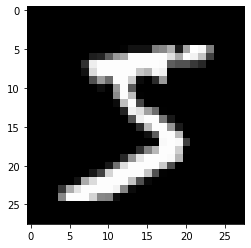

In [36]:
plt.imshow(train_images[0].reshape([28, 28]), cmap="gray")
print("Correct Label: %s" % train_labels[0])

### Das Modell


**Initialisierung der Weights 

Zunächst müssen die Weight- und Bias-Matrizen/Vektoren mit den richtigen Dimensionen erstellt werden. Zu diesem Zweck wird eine Funktion geschrieben. In ihr muss man die Größe der jeweiligen Layers (`input_size`, `hidden_size`, `output_size`) definieren. Mit diesen kann man die Weightmatrizen erstellen. Während die "b"-Vektoren mit Nullen gefüllt werden können, müssen die Weightsmatrizen mit zufälligen kleinen Zahlen initialisiert werden.


Die Funktion `np.random.randn(number_of_rows, number_of_columns)` setzt zufällige Werte zwischen minus Eins und plus Eins in die Matrix ein. Zusätzlich wird der Term`* np.sqrt(2/layer_size)` hinzugefügt. Dieser verkleinert die Werte noch weiter und soll damit ein besseres Trainieren des Netzwerkes garantieren. 

Im folgenden Code sollen Sie die richtigen Matrixgrößen (Anzahl der Reihen/Spalten) eintragen. Die Inputmatrix `X` hat 60000 Reihen und 784 Spalten und bei einer Matrixmultiplikation müssen die Anzahl der Spalten der ersten Matrix mit der Anzahl der Reihen der zweiten Matrix übereinstimmen.
Denken Sie auch daran, dass wir das Transpose der Weightmatrix benutzen werden.

Den Bias `b` wird mit Nullen initialisiert. `np.zeros(500)` würde ein Vektor der Länge 500 mit Nullen füllen.
Auch brauchen wir nicht die tatsächlichen Zahlen, sondern nur die Namen der Inputvariablen nennen,  also nicht 784, sondern `input_size`.
Die tatsächlichen Werte können dann bei der eigentlichen Benutzung der Funktion definiert werden.

In [ ]:
# Funktion zur intialisierung der Weights
def init_weights(input_size, hidden_size, output_size):
    # Zwei leere Listen mit Länge zwei
    b = [0] * 2
    W = [0] * 2

    # hier werden die Weights W mit kleinen, zufälligen Gewichten initialisiert
    
    W[0] = np.random.randn(        ,         ) * np.sqrt(2 / input_size)  # HIER MÜSSEN DIE RICHTIGEN GRÖßEN ANGEGBEN WERDEN
    W[1] = np.random.randn(        ,         ) * np.sqrt(2 / hidden_size) # HIER MÜSSEN DIE RICHTIGEN GRÖßEN ANGEGBEN WERDEN

    # der bias kann 0 sein
    b[0] = np.zeros(       ) # HIER MÜSSEN DIE RICHTIGEN GRÖßEN ANGEGBEN WERDEN
    b[1] = np.zeros(       ) # HIER MÜSSEN DIE RICHTIGEN GRÖßEN ANGEGBEN WERDEN


    return W, b

<details>
<summary><strong>Lösung:</strong></summary>

```python
def init_weights(input_size, hidden_size, output_size):
    # Zwei leere Listen mit Länge zwei
    b = [0] * 2
    W = [0] * 2

    # hier werden die Weights W mit kleinen, zufälligen Gewichten initialisiert
    
    W[0] = np.random.randn(hidden_size,input_size) * np.sqrt(2 / input_size)  
    W[1] = np.random.randn(output_size,hidden_size) * np.sqrt(2 / hidden_size) 

    # der bias kann 0 sein
    b[0] = np.zeros(hidden_size) # HIER MÜSSEN DIE RICHTIGEN GRÖßEN ANGEGBEN WERDEN
    b[1] = np.zeros(output_size) # HIER MÜSSEN DIE RICHTIGEN GRÖßEN ANGEGBEN WERDEN


    return W, b
```
</details>

Die Weights können nun initialisiert werden: 

Die Eingabegröße ist vordefiniert, da jedes Bild 784 Pixel hat. Die Ausgangsgröße ist ebenfalls vorgegeben, da das Netz zwischen 10 verschiedenen Ziffern unterscheiden muss.
Der einzige Wert, den Sie selbst festlegen können, ist die Größe der Hidden Layers. Es gibt keine einfache Regel für die Größe, aber wenn sie zu klein ist, kann sie die Genauigkeit des neuronalen Netzes verringern. Wenn sie zu groß ist, trainiert das Netz zu langsam und kann instabil werden. Dies kann sich ebenfalls auf die Genauigkeit auswirken. Versuchen Sie anfangs Werte wie 100 oder 200. 

Parameter wie die Größe der Hidden Layers oder die Lernrate, die Sie frei wählen können, werden als **Hyperparameter** bezeichnet. Anders als die eigentlichen Weights des Netzes werden diese nicht durch Backpropagation optimiert. Das muss "von Hand" geschehen. Dieser Vorgang wird als Hyperparameter-Optimierung bezeichnet.

Mit dieser Funktion können Sie nun die Weights initialisieren. Die Funktion gibt zwei Listen `W` und `b` aus. Die beiden Listen enthalten jeweils zwei Matrizen/Vektoren, einmal für die erste und einmal für die zweite Transformation.

In [37]:
W, b = init_weights(input_size=784, hidden_size=200,output_size= 10)

NameError: name 'init_weights' is not defined

In [ ]:
W[0].shape

Wenn Sie die Weights richtig initialisiert haben, sollte `W[0].shape` `(200,784)` sein.

---

Sie fragen sich vielleicht: Warum initialisieren wir unsere Weights nicht einfach mit ` W[0] = np.random.randn(input_size,hidden_size)`. Dann bräuchten wir später nicht das `.transpose()` zu verwenden, da die Matrizen bereits das richtige Format haben.

In der Tat ist dies möglich, aber diese Art der Initialisierung hat sich als Standard durchgesetzt. Um zukünftige Verwirrung zu vermeiden, folgen wir auch diesem Standard. 

---

**Forward Pass** 

Nachdem die Weights initialisiert wurden, können Sie den Forward Pass des Netwerkes durchführen. Die Bilder werden durch das Netz geschickt, das diese Bilder schließlich klassifiziert.
Die Funktion `forward_pass()` macht genau das. Ihr Input ist:

* `W`: die Liste der Weightmatrizen
* `b`: die Liste der Bias Vektoren
* `X`: die Inputmatrix der Bilder 



Als Erstes wird $Z_1 = xW_1^T+b_1$ berechnet. <br>
Dannach $A_1= sigmoid(Z_1)$

<br>
So werden die Activations für die Hidden Layers berechnet. Für die finale Klassifizierung müssen die Werte ein zweites Mal transformiert werden:<br>
$\hat{Y} = softmax(A_1W_2^T+b_2)$

Die Funktion gibt am Ende drei Variablen aus:
* `Z_1`: die Werte der ersten linearen Transformation
* `A_1`: die Werte nach der ersten Aktivierungsfunktion
* `Y_hat`: die Werte der Outputlayer 


*Denken Sie daran, dass die Weights der ersten Layer nicht in `W[1]`, sondern in `W[0]` gespeichert sind, da die Indexierung bei Null und nicht bei Eins anfängt.* 

*Denken Sie auch daran, dass wir zur Matrixmultiplikation* `np.matmul` *und nicht mehr* `np.dot` *benutzen.*

In [ ]:
def forward_pass(W, b, X):
    
    Z_1 = # CODE UM Z_1 AUZURECHNEN
    A_1 = # CODE UM A_1 AUSZURECHNEN
    Z_2 = # CODE UM Z_2 AUSZURECHNEN
    Y_hat = #CODE UM Y_HAT AUSZURECHNEN
    return Z_1, A_1, Y_hat

<details>
<summary><strong>Lösung:</strong></summary>

```python
def forward_pass(W, b, X):
    
    Z_1 = np.matmul(X,W[0].transpose())+b[0] # CODE UM Z_1 AUZURECHNEN
    A_1 = sigmoid(Z_1) # CODE UM A_1 AUSZURECHNEN
    Z_2 = np.matmul(A_1,W[1].transpose())+b[1] # CODE UM Z_2 AUSZURECHNEN
    Y_hat = softmax(Z_2) #CODE UM Y_HAT AUSZURECHNEN
    return Z_1, A_1, Y_hat
```
</details>

### Lossfunktion

Nach dem Forward Pass wird der Loss berechnet. Dieser misst, wie gut oder schlecht das Modell die Zahlen in den Bilder erkennen konnte.

Hierfür werden nur die Werte der Ausgabeschicht (`y_hat`) und die wahren Werte (`y`) verwendet. Die wahren Werte wurden zuvor mit der Funktion `one_hot` erstellt und sind in der Variable `train_targets` gespeichert. 

Sie haben bereits den Binary Crossentropy Loss kennengelernt, welcher für die binäre Klassifizierung verwendet wird. Diese Lossfunktion ist nur eine spezielle Version des Crossentropy Loss, welcher für die  Klassifizierung von mehr als zwei Klassen verwendet werden kann. Da wir nun versuchen, zehn verschiedene Zahlen zu unterscheiden, werden wir mit dem allgemeineren Crossentropy Loss weiterarbeiten. 

Die genaue Lossfunktion ist hier gebeben: 


In [ ]:
def calc_loss(y_hat, y):
    return -np.sum(np.log(y_hat) * y)

Sie können nun die ersten drei Funktionen zusammen verwenden, um Ihre erste Klassifizierung durchzuführen.
Denken Sie daran, dass die `train_images` der Input für das Netzwerk sind. Wir wollen, dass die versteckte Schicht 300 Knoten hat.

In [ ]:
np.random.seed(1234) # Ein Seed wird gesetzt, damit die Ergebnisse der zufälligen Initialisierung für alle Teilnehmer:innen gleich sind
W, b = # CODE, UM DIE WEIGHTS ZU INITIALISIEREN

# Benutzen Sie die train_images als X (Input)
Z_1, A_1, Y_hat = # CODE FÜR DEN FORWARD PASS

# Hier berechnen Sie den Loss
calc_loss(           ,           )/Y_hat.shape[0]

<details>
<summary><strong>Lösung:</strong></summary>

```python
np.random.seed(1234)
W, b = init_weights(784,300,10)

# Benutzen Sie die train_images als X (Input)
Z_1, A_1, Y_hat = forward_pass(W,b,train_images)
    
# Hier berechnen Sie den Loss
calc_loss(Y_hat,train_targets)/Y_hat.shape[0]
    
```
</details>


Wir berechnen zusätzlich die Accuracy, um einen genaueren Überblick darüber zu erhalten, wie gut unser Modell funktioniert.


In [38]:
def accuracy(true_labels,predicted):
    pred_labels = np.argmax(predicted, axis=1) # argmax gibt den Index des Maximalwertes wieder
    correct_predicted = np.sum(true_labels == pred_labels)
    return correct_predicted /correct_predicted.shape[0]

In [39]:
accuracy(train_labels,Y_hat)

NameError: name 'Y_hat' is not defined

Derzeit hat das Netzwerk eine Accuracy von 10,3 %. Eine Accuracy von 10 % ist zu erwarten, wenn das Netz nach dem Zufallsprinzip entscheidet.
Um eine bessere Genauigkeit über 10 % zu erreichen, müssen Sie das Netz trainieren bzw. die Weights verändern. Verwenden Sie dazu die Backpropagation.

**Backpropagation**

Die Fehler in der Klassifizierung werden nun durch das Netz zurückgeführt, und anhand der Gradienten werden die weights angepasst.

* $dZ_2 = \hat{y} - y$ 
* $dW_2 = \frac{1}{n} \cdot dZ_2^Ta_1$
* $db_2 = \frac{1}{n} \cdot \sum_{i=1}^n dZ_2$
* $dZ_1 = dZ_2W_2 \cdot a_1 \cdot (1-a_1)$
* $dW_1 = \frac{1}{n} \cdot dZ_1^TX$
* $db_1 = \frac{1}{n} \cdot\sum_{i=1}^n dZ_1$

Wie gesagt, wie die Ableitungen mathematisch zustande kommen, liegt außerhalb des Rahmens dieses Seminars. Für die konkrete Anwendung in späteren Übungen gibt es Libraries, die die Gradienten automatisch berechnen können. F Im Moment berechnen wir die Gradienten jedoch noch selbst.

In [ ]:
def back_prop(X, Z_1, A_1, Y_hat, y):
    n = X.shape[0] # n ist die Anzahl der Bilder
    
    # Gradients für die Weights der zweiten Layer
    dZ_2 =  # CODE UM dZ_2 AUZURECHNEN
    dW_2 =  # CODE UM dW_2 AUZURECHNEN
    db_2 = np.sum(dZ_2, axis=0) / n
    
    # Gradients für die Weights der ersten Layer
    dZ_1 = np.multiply(np.matmul(dZ_2, W[1]), np.multiply(A_1, 1 - A_1))
    dW_1 = # CODE UM dW_1 AUZURECHNEN
    db_1 = # CODE UM db_1 AUZURECHNEN

    return [dW_1, dW_2], [db_1, db_2] # Hier werden wieder zwei Listen als Output gegeben, in jeder der Listen befinden sich jeweils die Gradienten für W_1,W_2 und b_1 und b_2

<details>
<summary><strong>Lösung:</strong></summary>

```python
def back_prop(X, Z_1, A_1, Y_hat, y):
    n = X.shape[0] # n ist die Anzahl der Bilder
    # Gradients für die Weights der zweiten Layer
    dZ_2 = Y_hat - y
    dW_2 = np.matmul(dZ_2.transpose(), A_1) / n
    db_2 = np.sum(dZ_2, axis=0) / n
    
    # Gradients für die Weights der ersten Layer
    dZ_1 = np.multiply(np.matmul(dZ_2, W[1]), np.multiply(A_1, 1 - A_1))
    dW_1 = np.matmul(dZ_1.transpose(), X) / n
    db_1 = np.sum(dZ_1, axis=0) / n

    return [dW_1, dW_2], [db_1, db_2] 
```
    
</details>

### Weights updaten

Im letzten Schritt werden die Weights angepasst. Dazu werden die Weights ein wenig entgegen det Gradienten verschoben. 
Wie weit genau, hängt von der Lernrate `lr` ab. Je größer die Lernrate ist, desto größer sind die Schritte.
Wenn die Lernrate zu klein ist, kann das Training zu lange dauern oder das Netz kann in einem lokalen Minimum stecken bleiben. Ist die Lernrate zu groß, springt der Loss des Netzes zu stark, so dass keine optimale Performance garantiert werden kann.
Die Lernrate gehört, wie die Größe der Hidden Layer, zu den Hyperparametern.
<center>
<img src="https://sebastianraschka.com/images/blog/2015/singlelayer_neural_networks_files/perceptron_learning_rate.png" style="width: 800px;">
<h8><center>Quelle: Sebastian Raschka, https://sebastianraschka.com</center></h8>
</center>

In [ ]:
def update(W, b, grad_W, grad_b, lr=0.0001):
    W[0] = # CODE FÜR W[0]
    W[1] = # CODE FÜR W[1]
    b[0] = # CODE FÜR b[0]
    b[1] = # CODE FÜR b[1]

    return W, b # die Funktion gibt die neuen Weights und Biases aus (2 Listen)

<details>
<summary><strong>Lösung:</strong></summary>

```python
def update(W, b, grad_W, grad_b, lr=0.0001):
    W[0] = W[0] - lr * grad_W[0]
    W[1] = W[1] - lr * grad_W[1]
    b[0] = b[0] - lr * grad_b[0]
    b[1] = b[1] - lr * grad_b[1]

    return W, b # die Funktion gibt die neuen Weights und Biases aus
```
    
</details>



## Putting it all together

Jetzt können Sie alles zusammenfügen. Zuerst initialisieren Sie die Gewichte, dann werden der Input durch das Netz geführt und der Loss wird berechnet.  Dannach wird der Loss zurück durch das Netz geführt und die Gradienten berechnet. Mit Hilfe der Gradienten werden die Weights aktualisiert. Für die Lernrate verwenden Sie den Wert 0,1.

In [ ]:
# 1.WEIGHTS INITALISIEREN
np.random.seed(1234) 
W, b = init_weights(input_size=784, hidden_size=300,output_size= 10) 

# 2.FORWARD PROPAGATION
Z_1, A_1, Y_hat = forward_pass(W,b,train_images)

# 3.LOSS BERECHNEN
print("Loss beim ersten Durchlauf: ",calc_loss(Y_hat,train_targets)/Y_hat.shape[0], "\nGenauigkeit beim ersten Durchlauf:", accuracy(train_labels, Y_hat) )

# 4. BACKPROPAGATION
grad_W, grad_b = # CODE FÜR DIE BACKPROPAGATION
# 5. WEIGHTS UPDATEN
W, b = # WEIGHT UPDATE

<details>
<summary><strong>Lösung:</strong></summary>

```python
# 1.WEIGHTS INITALISIEREN
np.random.seed(1234) 
W, b = init_weights(input_size=784, hidden_size=300,output_size= 10) 

# 2.FORWARD PROPAGATION
Z_1, A_1, Y_hat = forward_pass(W,b,train_images)

# 3.LOSS BERECHNEN
print("Loss beim ersten Durchlauf: ",calc_loss(Y_hat,train_targets)/Y_hat.shape[0], "\nGenauigkeit beim ersten Durchlauf:", accuracy(train_labels, Y_hat) )

# 4. BACKPROPAGATION
grad_W, grad_b = back_prop(train_images, Z_1, A_1, Y_hat, train_targets)

# 5. WEIGHTS UPDATEN
W, b = update(W, b, grad_W, grad_b, lr = 0.1)
```
    
</details>



Der Loss und die Accuracy sind noch unverändert. Erst wenn Sie erneut den Input durch das Netzwerk schicken, können Sie den Effekt der aktualisierten Weights sehen.

In [ ]:
Z_1, A_1, Y_hat = forward_pass(W,b,train_images)

# jetzt berechnen Sie den Loss
print("Loss beim zweiten Durchlauf: ",calc_loss(Y_hat,train_targets)/Y_hat.shape[0], "\nGenauigkeit beim zweiten Durchlauf:", accuracy(train_labels, Y_hat) )

In der Tat nimmt der Loss ab und die Accuracy verbessert sich. Allerdings kann es auch während des Trainings zu einer kurzfristigen Verschlechterung kommen, was aber nicht weiter schlimm ist.  Der Effekt des Trainings wird oft erst nach mehreren Epochen sichtbar. Sie können den Trainingsschritt einfach wiederholen.
Um dies effizienter zu tun, schreiben Sie einfach einen `for-loop`:

In [ ]:
# 1.WEIGHTS INITALISIEREN
np.random.seed(1234)
W, b = init_weights(784, 300, 10)

EPOCHS= 50 # wie oft der Datensatz durch das Netzwerk geführt wird
for i in range(EPOCHS):
    
    # 2. FORWARD PROPAGATON
    Z_1, A_1, Y_hat = forward_pass(W, b,train_images)
    
    # 3. LOSS BERECHNEN
    loss = calc_loss(Y_hat, train_targets) / Y_hat.shape[0]
    acc = accuracy(train_labels, Y_hat)
    
    print(i, 
        "Training Loss: %.2f Training Accuracy: %.2f"
        % (loss, acc)
    )
    
    # 4. BACK PROPAGATION
    grad_W, grad_b = back_prop(train_images, Z_1, A_1, Y_hat, train_targets)
    
    # 5. WEIGHTS UPDATEN
    W, b = update(W, b, grad_W, grad_b, lr = 0.1)

Sie können bereits eine Verbesserung feststellen und erreichen eine Accuracy von 73 %. Allerdings dauert das Training sehr lange. Mit einer höheren Lernrate sollte das Training schneller vonstatten gehen. Versuchen Sie eine Lernrate von 0,3.

In [ ]:
np.random.seed(1234)
W, b = init_weights(784, 300, 10)
loss= []
EPOCHS= 50 # wie oft der Datensatz durch das Netzwerk geführt wird
for i in range(EPOCHS):
    Z_1, A_1, Y_hat = forward_pass(W, b,train_images)
    
    loss= calc_loss(Y_hat, train_targets) / Y_hat.shape[0]
    
    acc = accuracy(train_labels, Y_hat)
    
    print(i,
        "Training Loss: %.2f Training Accuracy: %.2f"
        % (loss, acc)
    )
    
    # BACK PROPAGATION
    grad_W, grad_b = back_prop(train_images, Z_1, A_1, Y_hat, train_targets)
    # WEIGHTS UPDATEN
    W, b = update(W, b, grad_W, grad_b, lr = 0.3 )
    

Bei einer Lernrate von 0,3 erreichen Sie nach 50 Epochen eine Genauigkeit von 78 %. Sie können das Netz noch weiter verbessern, indem Sie noch länger trainieren. 

Was müssten Sie am Code ändern, um für 25 weitere Epochen zu trainieren **ohne das Netz erneut von Beginn trainieren zu müssen**?

In [ ]:
np.random.seed(1234)
W, b = init_weights(784, 300, 10)
loss= []
EPOCHS= 25 # wie oft der Datensatz durch das Netzwerk geführt wird
for i in range(EPOCHS):
    Z_1, A_1, Y_hat = forward_pass(W, b,train_images)
    loss= calc_loss(Y_hat, train_targets) / Y_hat.shape[0]
    acc = accuracy(train_labels, Y_hat)
    print(
        "Training Loss: %.2f Training Accuracy: %.2f"
        % (loss, acc)
    )
    
    # BACK PROPAGATION
    grad_W, grad_b = back_prop(train_images, Z_1, A_1, Y_hat, train_targets)
    # WEIGHTS UPDATEN
    W, b = update(W, b, grad_W, grad_b, lr = 0.3)

<details>
<summary><strong>Lösung:</strong></summary>

```python
np.random.seed(1234)
# W, b = init_weights(784, 300, 10) # Sie dürfen nicht erneut die Gewichte initialisieren
loss= []
EPOCHS= 25 # wie oft der Datensatz durch das Netzwerk geführt wird
for i in range(EPOCHS):
    Z_1, A_1, Y_hat = forward_pass(W, b,train_images)
    loss= calc_loss(Y_hat, train_targets) / Y_hat.shape[0]
    acc = accuracy(train_labels, Y_hat)
    print(
        "Training Loss: %.2f Training Accuracy: %.2f"
        % (loss, acc)
    )
    
    # BACK PROPAGATION
    grad_W, grad_b = back_prop(train_images, Z_1, A_1, Y_hat, train_targets)
    # WEIGHTS UPDATEN
    W, b = update(W, b, grad_W, grad_b, lr = 0.3)
```
    
</details>



Sie dürfen die Weights einfach nicht erneut initialisieren. Sonst wird alles verloren, was das Netz bereits gelernt hat.

Durch weiteres Training haben Sie das Netz um 6% Accuracy verbessern können. Grundsätzlich haben Sie noch die Möglichkeit, etwas an der Größe der Hidden Layers zu ändern. 

Bevor wir das tun, können Sie zunächst sehen, wie gut unser Modell bei Bildern funktioniert, die es noch nicht gesehen hat. Wir sprechen hier von dem Testdatensatz. Zu diesem Zweck wird der Testdatensatz in das trainierte Netzwerk eingespeist:

In [40]:
_, _, test_y_hat = forward_pass(W, b, test_images) # durch das _,_,test_y_hat werden z_1 und a_1 nicht mit ausgegeben, da wir diese nicht brauchen
accuracy(test_labels, test_y_hat)   

NameError: name 'forward_pass' is not defined

Die Accuracy für den Testdatensatz beträgt ebenfalls 85 %. Oder: 85 % der Bilder wurden richtig erkannt.
Es ist ungewöhnlich, dass Netzwerke auf dem Testdatensatz besser oder gleich gut abschneiden. Dies ist ein Hinweis darauf, dass Sie das Modell nicht lange genug trainiert haben.

Als Nächstes können Sie sich ansehen, mit welchen Bildern das Netz die meisten Probleme hat.
Der Code in der nächsten Zelle sortiert die falsch erkannten Bilder nach ihrer Wahrscheinlichkeit (dieser Code ist nicht unbedingt einfach zu verstehen, aber für das Verständnis neuronaler Netze auch nicht unbedingt notwendig):

In [41]:
falsche_klassifizierung = np.where(test_labels != np.argmax(test_y_hat, axis=1))[0]# welche Bilder wurde falsch klassifiziert
len(falsche_klassifizierung) # soviele Bilder wurden falsch klassifiziert

NameError: name 'test_y_hat' is not defined

In [ ]:
# Hier werden de Wahrscheinlichkeiten gesammelt die das Model dem Bild zugeorndet hat in der richtige Kategorie zu sein
probs = [] 
for image in falsche_klassifizierung:
    probs.append(test_y_hat[image,test_labels[image]])

In [ ]:
# Wir sortieren die Bilder Anhand der Wahrscheinlichkeiten, je kleiner die Wahrscheinlichkeit desto sicherer war das Model das das Bild nicht in der richtige Katehorie ist
falsche_klassifizierung=falsche_klassifizierung[np.argsort(probs)]

In [ ]:
# so sehen 10 Bilder aus die falsch klassifiziert werden
for i in range(10):
    plt.imshow(test_images[falsche_klassifizierung[i]].reshape([28, 28]), cmap="gray")
    plt.show()
    print(
        "Predicted Label: %s, Correct Label %s"
        % (
            np.argmax(test_y_hat, axis=1)[falsche_klassifizierung[i]],
            test_labels[falsche_klassifizierung[i]],
        )
    )

Bei einigen Bildern kann man deutlich erkennen, warum sie falsch kategorisiert wurden. Bei anderen hingegen ist es für das menschliche Auge recht einfach, die richtige Ziffer zu erkennen, aber das Netzwerk hat Probleme damit.

# Übungsaufgabe

Schreiben Sie den obrigen Code so um, dass sowohl Test Accuracy und Test Loss nach jedem Epoch berechnet und ausgegeben werden. Dies soll zusätzlich zu der Trainings Accuracy/Loss passieren.

In [ ]:
np.random.seed(1234)
W, b = init_weights(784, 300, 10)
loss= []
EPOCHS= 25 # wie oft der Datensatz durch das Netzwerk geführt wird
for i in range(EPOCHS):
    z_1, a_1, y_hat = forward_pass(W, b,train_images)
    loss= calc_loss(y_hat, train_targets) / y_hat.shape[0]
    acc = accuracy(train_labels, y_hat)
    print(
        "Training Loss: %.2f Training Accuracy: %.2f"
        % (loss, acc)
    )
    
    # wir machen die backpropagation
    grad_W, grad_b = back_prop(train_images, z_1, a_1, y_hat, train_targets)
    # und mit den Gradienten updaten wir die Weights
    W, b = update(W, b, grad_W, grad_b, lr = 0.3)